# Part 1. Segmentation — 10 points

### Task

Train a neural network to segment cells edges.

In this task, you won't be provided with any code snippets, just input data and target metric — intersection-over-union (IoU) (see the implementation below).

You should train your neural network to predict a mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you have learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions), we recommend using UNet: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You are not allowed to do only one thing: to train you network on a test set.

The final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

A good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain similar or better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [ ]:
### Download the dataset ###
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

--2020-05-11 19:54:27--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-05-11 19:54:27--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdb6657bf72300880b6a304c35.dl.dropboxusercontent.com/cd/0/inline/A3gijNZWr4p1BZN5wHAJM7nhuUWMqQfLTVxas5Aij4wPPQz47H3tcJ4YVv77xRW47x6rEkCknQ66KDn1pX0XVMaaKuiJqbZdsgwbsM9tzh1RhA/file# [following]
--2020-05-11 19:54:28--  https://uccdb6657bf72300880b6a304c35.dl.dropboxusercontent.com/cd/0/inline/A3gijNZWr4p1BZN5wHAJM7nhuUWMqQfLTVxas5Aij4wPPQz47H3tcJ4YVv77xRW47x6rEkCknQ66KDn1pX0XVMaaKuiJqbZdsgwbsM9tzh1RhA/file
Resolving uccdb6657bf723

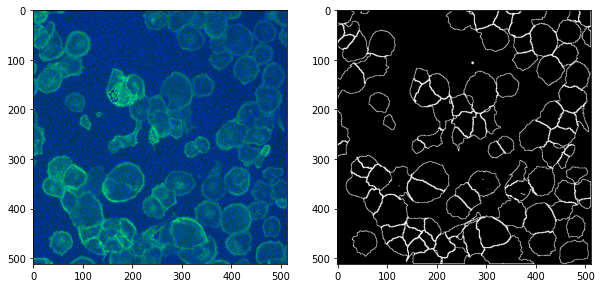

In [ ]:
### Visualize the data ###
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline



# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [ ]:
import torch
import random
from torch.utils import data
import torchvision.transforms.functional as TF

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, list_IDs, labels, transform_x = None, transform_y = None):
        'Initialization'
        self.labels = labels
        self.data = data
        self.list_IDs = list_IDs
        self.transform_x = transform_x
        self.transform_y = transform_y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        seed = np.random.randint(2147483647)
        X = np.array(self.data[ID])
        y = np.array(self.labels[ID])
        random.seed(seed)
        if self.transform_x is not None:
          random.seed(seed)
          X = self.transform_x(X)
          random.seed(seed)
          y = self.transform_x(y)

        return X, y

In [ ]:
import cv2
import os
import glob

def get_data(path, labels = True):
  train_dir = "./BBBC018_v1_images-fixed/" + path # Enter Directory of all images 
  data_path = os.path.join(train_dir,'**')
  files = glob.glob(data_path)
  idx = []
  train_data = []
  for f1 in files:
      img = io.imread(f1)
      idx.append(f1[len(train_dir):len(train_dir)+5])
      train_data.append(img)
  if labels:
    train_dir = "./BBBC018_v1_outlines/" + path
    train_labels = []
    for i in idx:
        img = io.imread(train_dir + i + '-cells.png')
        train_labels.append(img)    
    return train_data, train_labels
  else:
    return idx, train_data 

In [ ]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm    # run this in Colab
from tqdm import tqdm               # or this in Jupyter instead

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

In [ ]:
experiment_title = "unet"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 4
image_size = 512

transform_x = transforms.Compose([
    transforms.ToPILImage(),                            
    transforms.RandomResizedCrop(size = image_size, scale = (0.6,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    transforms.RandomRotation(90),
    transforms.ToTensor()
])
transform_y = transforms.Compose([
    transforms.ToPILImage(),                            
    transforms.RandomResizedCrop(size = image_size, scale = (0.5,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ToTensor()
])

In [ ]:
train_data, train_labels = get_data('train/')

training_set = Dataset(train_data, np.arange(len(train_data)), train_labels, transform_x= transform_x)
train_dataloader = data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# UNetDownBlock: Conv + ReLU + Conv + ReLU + MaxPool

class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        # your code here
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        # x: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

In [ ]:
# UNetUpBlock: upsampling + concat + Conv + ReLU

class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # your code here
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x, x_bridge):
        # x: a tensor of shape (batch_size, in_channels, layer_height // 2, layer_width // 2)
        # x_bridge: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out

In [ ]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4),
            #UnetDownBlock(n_base_channels * 4, n_base_channels * 4)
        ])
        self.up_blocks = nn.ModuleList([
           # UnetUpBlock(n_base_channels * 4, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            #  nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            nn.Conv2d(n_base_channels, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
            # easy mistake can be made here: for last layer, we need to save out_before_pooling
        out = before_pooling

        # now outputs_before_pooling = [block1_before_pooling, ..., block5_before_pooling]
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [ ]:
model = Unet(n_base_channels=8).to(device)

In [ ]:
criterion = torch.nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

experiment_name: unet@11.05.2020-19:56:03


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor()
])

In [ ]:
val_data, val_labels = get_data('val/')

valid_dataset = Dataset(val_data, np.arange(len(val_data)), np.asarray(val_labels)[:,:,:,None], transform_x = transform, transform_y = transform)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=2)

In [ ]:
n_epochs = 1 #400

for epoch in range(n_epochs):
    model.train()
    n_iters = 0
    losses = []
    for batch in tqdm(train_dataloader):
        # unpack batch
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        # forward
        map_image_pred_batch = model(photo_image_batch)
        #print(map_image_pred_batch[0][0][20])
        t = torch.Tensor([0.30]).to(device)  # threshold
        prediction = (map_image_pred_batch > t).float() * 1.0
        loss = criterion(map_image_pred_batch, map_image_batch)
        losses.append(loss.item())

        #print(prediction[0][0][20])
        #print(calc_iou(prediction.detach().cpu().numpy() , map_image_batch.detach().cpu().numpy() ))
        
        # optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=epoch * len(train_dataloader) + n_iters)
        if n_iters % 50 == 20:
            plt.figure(figsize=(10,8))
            plt.subplot(1,2,1)
            plt.imshow(prediction[0].resize_((512,512)).detach().cpu().numpy(), 'gray')
            plt.subplot(1,2,2)
            plt.imshow(map_image_batch[0].resize_((512,512)).detach().cpu().numpy(), 'gray')
            plt.show()
            writer.add_image('train/photo_image', torchvision.utils.make_grid(photo_image_batch) * 0.5 + 0.5, epoch * len(train_dataloader) + n_iters)
            writer.add_image('train/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch), epoch * len(train_dataloader) + n_iters)
            writer.add_image('train/map_image_gt', torchvision.utils.make_grid(map_image_batch), epoch * len(train_dataloader) + n_iters)
        
        n_iters += 1
    print(np.mean(losses))
    # your code here
    model.eval()
    n_iters = 0
    batch_losses = []
    for batch in valid_dataloader:
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        map_image_pred_batch = model(photo_image_batch)
        for thresh in np.linspace(0.25, 0.27 ,10): #[0.26]
          t = torch.Tensor([thresh]).to(device)  # threshold
          prediction = (map_image_pred_batch > t).float() * 1.0
#          plt.figure(figsize=(10,8))
#          plt.subplot(1,2,1)
#          plt.imshow(prediction[0].resize_((512,512)).detach().cpu().numpy(), 'gray')
#          plt.subplot(1,2,2)
#          plt.imshow(map_image_batch[0].resize_((512,512)).detach().cpu().numpy(), 'gray')
#          plt.show()
          print(calc_iou(prediction.detach().cpu().numpy() , map_image_batch.detach().cpu().numpy() ))
        
        
        loss = criterion(map_image_pred_batch, map_image_batch)
        batch_losses.append(loss.item())

        if n_iters < 5:
            writer.add_image(f'val_{n_iters}/photo_image', torchvision.utils.make_grid(photo_image_batch) * 0.5 + 0.5, 
                             epoch * len(valid_dataloader) + n_iters)
            writer.add_image(f'val_{n_iters}/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch), 
                             epoch * epoch * len(valid_dataloader) + n_iters)
            writer.add_image(f'val_{n_iters}/map_image_gt', torchvision.utils.make_grid(map_image_batch), 
                             epoch * epoch * len(valid_dataloader) + n_iters)
        n_iters += 1
    loss_averaged = np.mean(batch_losses)
    writer.add_scalar('val/loss_averaged', loss_averaged.item(), epoch)
    
    print("Epoch {} done with loss ".format(epoch), loss_averaged.item())

100%|██████████| 11/11 [00:01<00:00,  9.29it/s]

0.077938896688548


0.2938423719763447
0.29413974073961285
0.2944531985429542
0.29441658377185975
0.29442407370859347
0.2944035492494991
0.2946224768973679
0.2945704744663117
0.2946752712088241
0.29471297303702426
Epoch 0 done with loss  0.12585879862308502


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "./gdrive/My Drive/"
base_dir = root_dir + 'models/'

Mounted at /content/gdrive


In [ ]:
!ls gdrive/'My Drive'/models

 00733.png   13569.png		   logs
 05624.png   19466.png		   resnet18
 05899.png   64_no_pre		  'Screenshot from 2020-04-29 21-15-59.png'
 10780.png  'checkpoint (1).pth'
 13361.png   checkpoint.pth


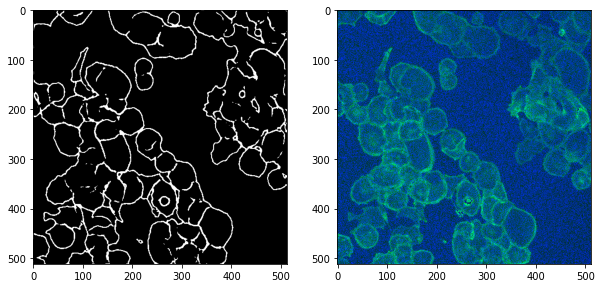

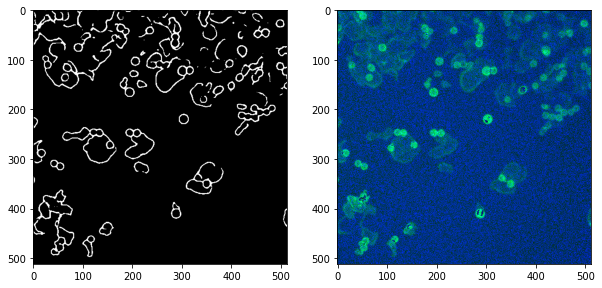

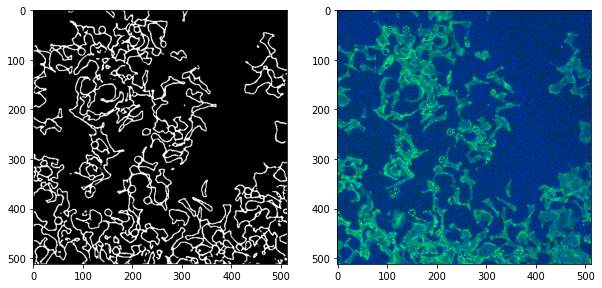

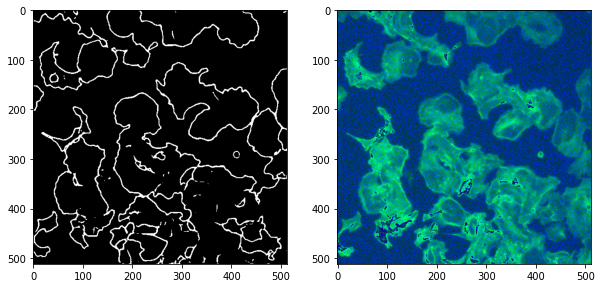

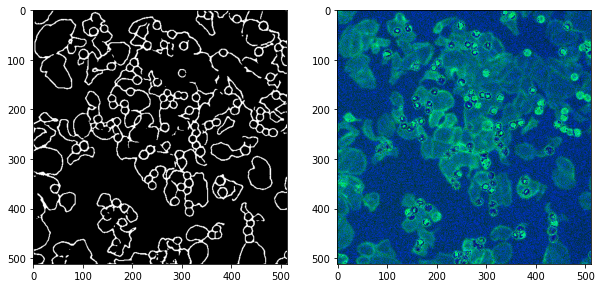

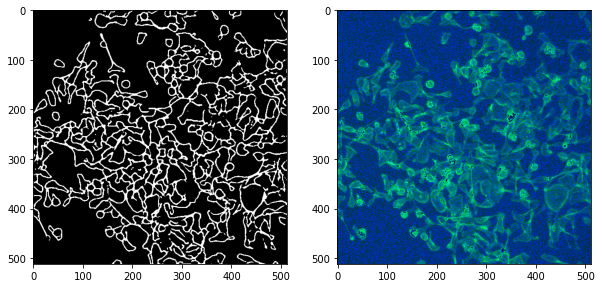

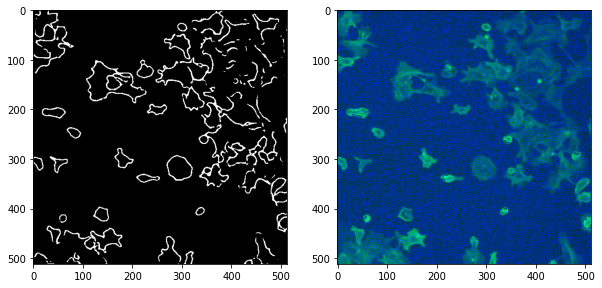

In [ ]:
import scipy.misc
import matplotlib


idx, test_data = np.array(get_data('test/', labels = False))
for i in range(7):
  test_item = transform(test_data[i]).to(device)
  test_edges = model(test_item[None,...])


  t = torch.Tensor([0.26]).to(device)  # threshold
  prediction = (test_edges > t).float() * 1.0
  plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  im_array = prediction[0].resize_((512,512)).detach().cpu().numpy()
  plt.imshow(im_array, 'gray')
  matplotlib.image.imsave(base_dir + idx[i] + '.png', im_array)
  plt.subplot(1,2,2)
  plt.imshow(test_data[i], 'gray')
  plt.show()

# Part 2. Deep Image Prior (DIP) — 10 points


### Theory

Deep Image Prior [1] can be viewed as an implicit conditional generative model:

\begin{equation}
p(x \mid x_0) = \int p(x \mid \theta, \mathcal{z}, x_0)\, p(\theta \mid x_0)\, p(\mathcal{z})\,d\theta\,d\mathcal{z}\,,
\end{equation}

Latent parameters of this model consist of the weights of the neural network $\theta$ and a fixed input $\mathcal{z}$, which is fed into the network. 

If we denote the network by $f$, the output $x$ is produced in the following way:

$$
x = f_\theta(\mathcal{z}).
$$

This this model is implicit: we cannot evaluate the integral above. In the case of DIP, both likelihood and prior are unknown. But, as with all implicit models, we can perform sampling from $p(x \mid x_0)$.

Similarly to style transfer models, the sampling is done via optimization. The algorithm is following:

1. Sample a data point $x_0$ from a data distribution.
2. Initialize $\theta$ with $\theta_0$ and $\mathcal{z}$ with $z$.
3. Perform an optimization of some error function $E$ with respect to the weights of the neural network: 

$$
\min_\theta E(f_\theta(z), x_0).
$$

4. Hand-pick the weights $\theta_M$ at intermediate optimization step $M$ and denote them as $\theta^*$

Now, the most counter-intuitive thing about this model is the fact that it can be used for image restoration (inpainting, denoising) and super-resolution. In this case, $x_0$ is a degraded version of a target image $x$. And, by trying to predict this degraded image using a network (via minimization of an error between the predicted image $f_\theta(z)$ and $x_0$) at some optimization step $M$ we will obtain its restored or upscaled version.

The main trick is that instead of optimizing with respect to an input tensor $z$, like in style-transfer models, we keep the input fixed and optimize with repect to the weights of the network. Brief explanation of this result is provided below, for more details please refer to [1].

On one hand, a convolutional neural network is close to a universal functional approximator, and, given enough training iterations, it can fit a manifold of arbitrary complexity [2]. On the other hand, it is observed in practice that early stopping leads to solutions with good generalization (same networks, as in [2], can be properly trained to achieve good generalization). In DIP paper this phenomena is explored for image synthesis, and it was shown that the same intuition about generalization also applies here. Remarkably though, the generalization results were obtained for a highly complex manifold of natural images, which once again shows how well-suited are convolutional neural networks for image processing and synthesis.

### Task

The general goal of the task is for you to reproduce the results from the paper:

using a Mean Square Error (MSE) as an error function,

1. perform denoising of the images in the folder "data/denoising",
2. perform inpaiting of the images in the folder "data/inpaiting" (for inpainting, apply the loss only over the known area of the image using a provided mask),

with a UNet-style network (with 4 downsampling layers, and 16, 32, 64 and 128 filters at the end of each block).

For architecture reference, please read this blog post:
https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5.

If you have used a UNet-style network in the first part of the assignment on segmentation, you can reuse the code.

### Notes

- You have to play with the number of iterations $M$ used for early stopping, and use the optimal value to denoise and inpaint the images from the task. For each task you may need to find different optimal values. The source code and the results of your experiments should be provided in this notebook.
- Use Adam as your default optimizer, but feel free to experiment with the other optimizers or even architectures of the network. The most thorough experiments will be graded with bonus points. The final score for the homework is calculated as $\min ( \text{points} + \text{bonus_points}, \text{max_points} ) $.

### References

[1] Ulyanov et. al., "Deep Image Prior", CVPR 2018, https://arxiv.org/abs/1711.10925

[2] Zhang et. al., "Understanding deep learning requires rethinking generalization", ICLR 2017, https://arxiv.org/abs/1611.03530

In [ ]:
### Download the dataset ###
!wget https://www.dropbox.com/s/si5o4dp4qa59cyy/data.zip?dl=0 -O data.zip
!unzip -q data.zip

--2020-05-13 05:12:08--  https://www.dropbox.com/s/si5o4dp4qa59cyy/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si5o4dp4qa59cyy/data.zip [following]
--2020-05-13 05:12:08--  https://www.dropbox.com/s/raw/si5o4dp4qa59cyy/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd58bf8e22379ae86d240d37f37.dl.dropboxusercontent.com/cd/0/inline/A3nGEXgcat13PteUo4xlS7yx9bAycHqBkUwxpxXsLN57qIRyFH5yH-nRfKhe1Ghj_SN3lRDM3LUmJv-f_wX1jOuqBnd03wAnNsHCea3HEMNJJfyKktFodcQOCX7N_odUIdM/file# [following]
--2020-05-13 05:12:08--  https://ucd58bf8e22379ae86d240d37f37.dl.dropboxusercontent.com/cd/0/inline/A3nGEXgcat13PteUo4xlS7yx9bAycHqBkUwxpxXsLN57qIRyFH5yH-nRfKhe1Ghj_SN3lRDM3LUmJv-f_wX1jOuqBnd03wAnNsHCea3HEMNJJfyKktFodcQOC

In [ ]:
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

def im_open(path, distr = False):
    #img = Image.open('data/denoising/snail.jpg')
    img = Image.open(path)
    dx, dy = img.size
    dx = dx % 32
    dy = dy % 32
    box = [(dx + 1) // 2, (dy + 1) // 2, img.size[0] - dx // 2, img.size[1] - dy // 2]

    img_new = img.crop(box)

    ar = np.array(img_new)
    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]
    x = ar.astype(np.float32) / 255.
    z = torch.zeros(x.shape)
    z.uniform_(0, 0.1)
    if distr:
      z.normal_(mean=0.2)
    return x, z

In [ ]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8),
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 8, n_base_channels * 8),
            UnetUpBlock(n_base_channels * 8, n_base_channels * 8),
            UnetUpBlock(n_base_channels * 8, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            #nn.Conv2d(n_base_channels, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
            # easy mistake can be made here: for last layer, we need to save out_before_pooling
        out = before_pooling

        # now outputs_before_pooling = [block1_before_pooling, ..., block5_before_pooling]
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np

import torch
import torch.optim

from skimage.measure import compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
plane, z = im_open('data/denoising/F16_GT.png')
noise = np.random.normal(scale = 0.1, size = plane.shape)
plane += noise

In [ ]:
net_input = torch.Tensor(z)[None,...].to(device)
res = torch.Tensor(plane)[None,...].to(device)
LR = 0.0015

num_iter = 5300

net = Unet(n_base_channels=16).to(device)
net = net.type(dtype)
params = net.parameters()

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = torch.from_numpy(plane)[None, :].type(dtype)

optimizer = torch.optim.Adam(params, lr=LR)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

Num iter 5199  loss =  0.01027365680783987


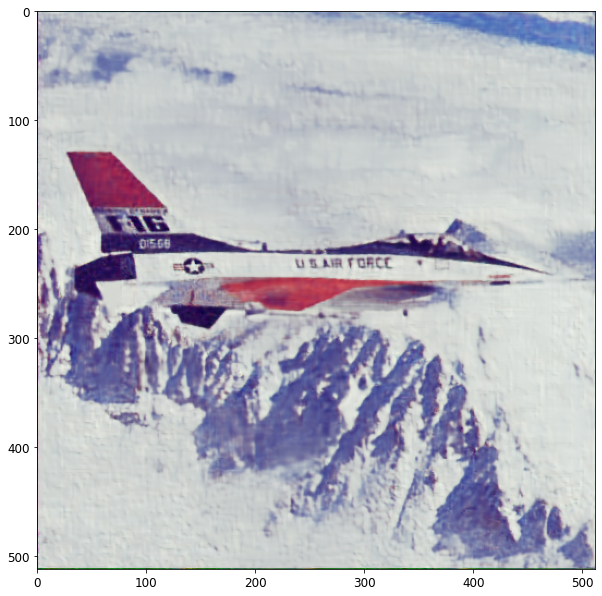

In [ ]:
def closure(reg = torch.Tensor([0]).to(device)):
    noise = torch.zeros_like(net_input).to(device)
    noise.normal_
    out = net(net_input + reg * noise)
            
    total_loss = mse(out, res)
    total_loss.backward()
    return total_loss, out

for j in range(num_iter):
    optimizer.zero_grad()
    loss_, plane_image = closure(reg = torch.Tensor([0.05]).to(device))
    if j % 200 == 199:
      display.clear_output(wait=True)
      plt.figure(figsize=(10, 12))
      print('Num iter', j, ' loss = ',loss_.item())
      plt.imshow(plane_image.detach().cpu().numpy()[0].transpose(1,2,0))
      plt.show()
    optimizer.step()

### Original image
as it can be seen denoising worked quite well, however, sometimes the number under F16 can't be recognized and "u.s. air force" sometimes is sharper.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


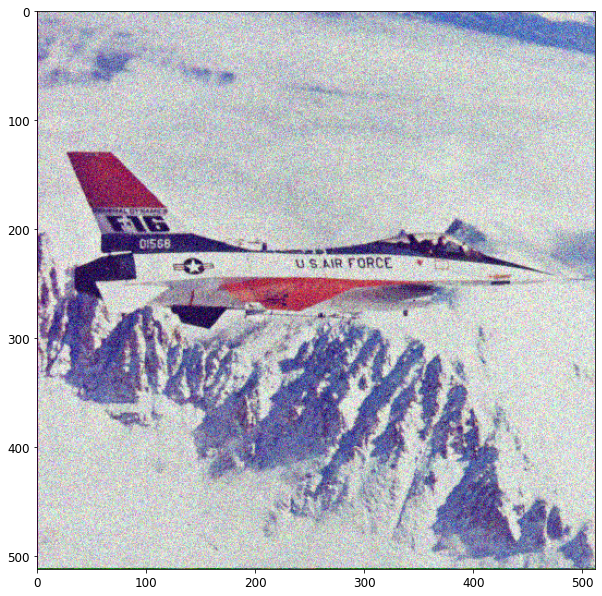

In [ ]:
plane_original = res
plt.figure(figsize=(10, 12))
plt.imshow(res.detach().cpu().numpy()[0].transpose(1,2,0))

In [ ]:
snail, z = im_open('data/denoising/snail.jpg')

In [ ]:
net_input = torch.Tensor(z)[None,...].to(device)
res = torch.Tensor(snail)[None,...].to(device)
LR = 0.001

num_iter = 3300

net = Unet(n_base_channels=16).to(device)
net = net.type(dtype)
params = net.parameters()

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = torch.from_numpy(snail)[None, :].type(dtype)

optimizer = torch.optim.Adam(params, lr=LR)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

Num iter 3299  loss =  0.0008674556156620383


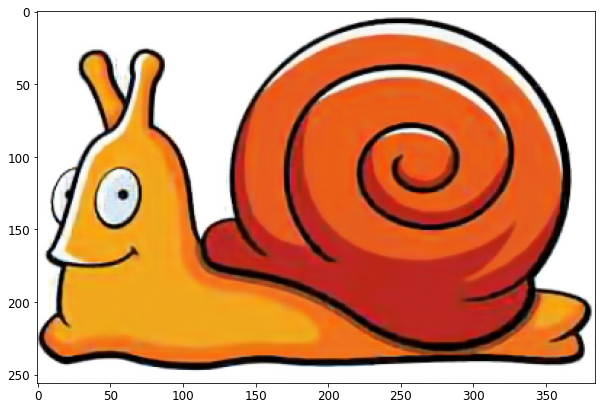

In [ ]:
def closure(reg = torch.Tensor([0]).to(device)):
    noise = torch.zeros_like(net_input).to(device)
    noise.normal_
    out = net(net_input + reg * noise)
            
    total_loss = mse(out, res)
    total_loss.backward()
    return total_loss, out

for j in range(num_iter):
    optimizer.zero_grad()
    loss_, snail_image = closure(reg = torch.Tensor([0.015]).to(device))
    if j % 100 == 99:
      display.clear_output(wait=True)
      plt.figure(figsize=(10, 12))
      print('Num iter', j, ' loss = ',loss_.item())
      plt.imshow(snail_image.detach().cpu().numpy()[0].transpose(1,2,0))
      plt.show()
    optimizer.step()


### Original image

Sometimes it worked better and noise in the shadow parts of snail looked smoother.

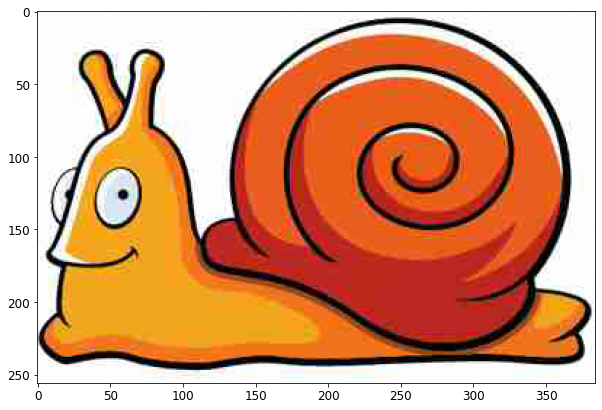

In [ ]:
snail_original = res
plt.figure(figsize=(10, 12))
plt.imshow(res.detach().cpu().numpy()[0].transpose(1,2,0))

In [ ]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)

# UNetUpBlock: upsampling + concat + Conv + ReLU

class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # your code here
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(),
        )
        
    def forward(self, x, x_bridge):
        # x: a tensor of shape (batch_size, in_channels, layer_height // 2, layer_width // 2)
        # x_bridge: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        x_up = self.upsample(x)
#        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_up)
        
        return out
        
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        # your code here
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # x: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 16),
            UnetDownBlock(n_base_channels * 16, n_base_channels * 16),
            UnetDownBlock(n_base_channels * 16, n_base_channels * 16),
            UnetDownBlock(n_base_channels * 16, n_base_channels * 16),
            UnetDownBlock(n_base_channels * 16, n_base_channels * 16),
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 16, n_base_channels * 16),                               
            UnetUpBlock(n_base_channels * 16, n_base_channels * 16),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 16),
            UnetUpBlock(n_base_channels * 16, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            #nn.Conv2d(n_base_channels, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
            # easy mistake can be made here: for last layer, we need to save out_before_pooling
        out = before_pooling
        # now outputs_before_pooling = [block1_before_pooling, ..., block5_before_pooling]
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [ ]:
kate, z = im_open('data/inpainting/kate.png', distr = True)
mask, _ = im_open('data/inpainting/kate_mask.png')

net_input = torch.Tensor(z)[None,...].to(device)
res = torch.Tensor(kate)[None,...].to(device)
mask_res = torch.Tensor(mask)[None,...].to(device)
LR = 0.001

num_iter = 5500

net = Unet(n_base_channels=8).to(device)
net = net.type(dtype)
params = net.parameters()

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = torch.from_numpy(kate)[None, :].type(dtype)

optimizer = torch.optim.Adam(params, lr=LR)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

Num iter 5499  loss =  0.0002702065685298294


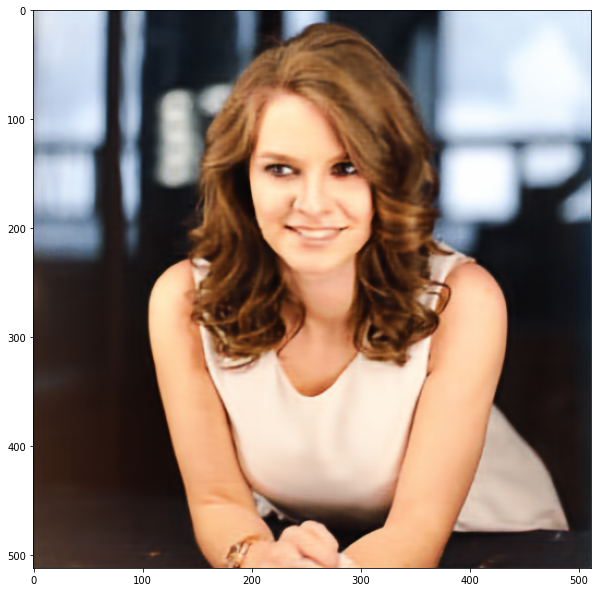

In [ ]:
def closure(reg = torch.Tensor([0]).to(device)):
    for n in [x for x in net.parameters() if len(x.size()) == 4]:
          n = n + n.detach().clone().normal_() * n.std() / 100
    noise = torch.zeros_like(net_input).to(device)
    noise.normal_
    out = net(net_input + reg * noise)
    total_loss = mse(out * mask_res, res * mask_res)
    total_loss.backward()
    return total_loss, out

for j in range(num_iter):
    optimizer.zero_grad()
    loss_, kate_image = closure(reg = torch.Tensor([0.0]).to(device))
    if j % 100 == 99:
      display.clear_output(wait=True)
      plt.figure(figsize=(10, 12))
      print('Num iter', j, ' loss = ',loss_.item())
      plt.imshow(kate_image.detach().cpu().numpy()[0].transpose(1,2,0))
      plt.show()
    optimizer.step()

### Original image

The picture became less precise, and I don't know why sometimes lips are reconstructed well and sometimes they are nude instead of pink. I tried Unet with more layers, with another chain of channel amounts, but it didn't work well.

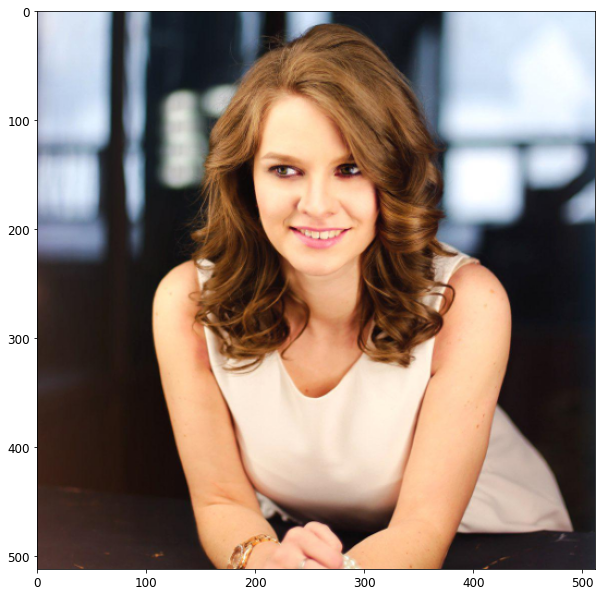

In [ ]:
kate_original = res
plt.figure(figsize=(10, 12))
plt.imshow(res.detach().cpu().numpy()[0].transpose(1,2,0))

In [ ]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)

# UNetUpBlock: upsampling + concat + Conv + ReLU

class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        # your code here
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
        )
        
    def forward(self, x, x_bridge):
        # x: a tensor of shape (batch_size, in_channels, layer_height // 2, layer_width // 2)
        # x_bridge: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        x_up = self.upsample(x)
#        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_up)
        
        return out

# UNetDownBlock: Conv + ReLU + Conv + ReLU + MaxPool

class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        # your code here
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        # x: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

class Unet(nn.Module):
    def __init__(self, n_base_channels=64):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8),
        ])
        self.up_blocks = nn.ModuleList([                               
            UnetUpBlock(n_base_channels * 8, n_base_channels * 8),
            UnetUpBlock(n_base_channels * 8, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            #nn.Conv2d(n_base_channels, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        
        # your code here
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
            # easy mistake can be made here: for last layer, we need to save out_before_pooling
        out = before_pooling
        # now outputs_before_pooling = [block1_before_pooling, ..., block5_before_pooling]
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [ ]:
lib, z = im_open('data/inpainting/library.png')
mask, _ = im_open('data/inpainting/library_mask.png')

In [ ]:
net_input = torch.Tensor(z)[None,...].to(device)
res = torch.Tensor(lib)[None,...].to(device)
mask_res = torch.Tensor(mask)[None,...].to(device)
LR = 0.0015

num_iter = 7200

net = Unet(n_base_channels=16).to(device)
net = net.type(dtype)
params = net.parameters()

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = torch.from_numpy(lib)[None, :].type(dtype)

optimizer = torch.optim.Adam(params, lr=LR)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

Num iter 7199  loss =  0.0014654609840363264


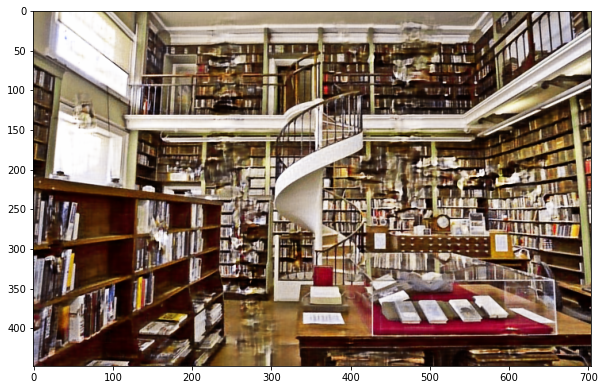

In [ ]:
def closure(reg = torch.Tensor([0]).to(device)):
    for n in [x for x in net.parameters() if len(x.size()) == 4]:
          n = n + n.detach().clone().normal_() * n.std() / 100
    noise = torch.zeros_like(net_input).to(device)
    noise.normal_
    out = net(net_input + reg * noise)
    total_loss = mse(out * mask_res, res * mask_res)
    total_loss.backward()
    return total_loss, out

for j in range(num_iter):
    optimizer.zero_grad()
    loss_, lib_image = closure(reg = torch.Tensor([0.0]).to(device))
    if j % 100 == 99:
      display.clear_output(wait=True)
      plt.figure(figsize=(10, 12))
      print('Num iter', j, ' loss = ',loss_.item())
      plt.imshow(lib_image.detach().cpu().numpy()[0].transpose(1,2,0))
      plt.show()
    optimizer.step()


### Original image

as it can be seen there are a lot of artefacts, but I think, looking very afar the colors look normally and quite good. In this case I wasn't sure which amount of iterations to choose, because all results looked quite strange.

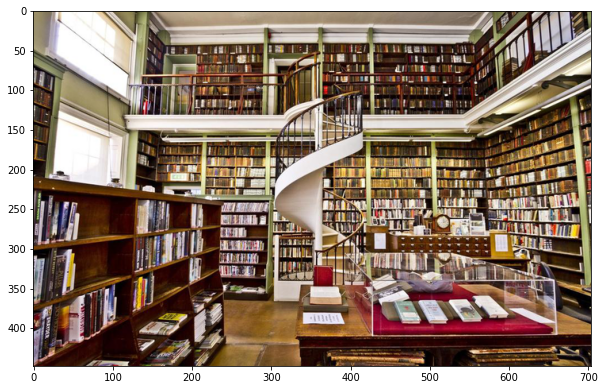

In [ ]:
lib_original = res
plt.figure(figsize=(10, 12))
plt.imshow(res.detach().cpu().numpy()[0].transpose(1,2,0))

In [ ]:
vase, z = im_open('data/inpainting/vase.png')
mask, _ = im_open('data/inpainting/vase_mask.png')

net_input = torch.Tensor(z)[None,...].to(device)
res = torch.Tensor(vase)[None,...].to(device)
mask_res = torch.Tensor(mask)[None,...].to(device)
LR = 0.001

num_iter = 4300

net = Unet(n_base_channels=16).to(device)
net = net.type(dtype)
params = net.parameters()

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = torch.from_numpy(vase)[None, :].type(dtype)

optimizer = torch.optim.Adam(params, lr=LR)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

Num iter 4299  loss =  0.0013784724287688732


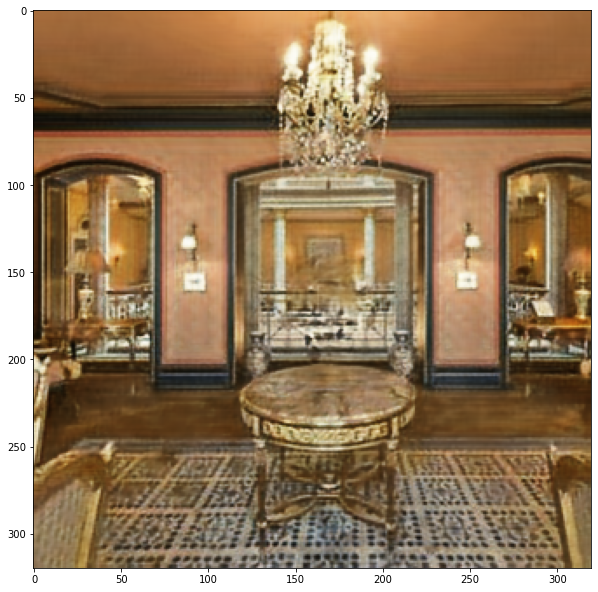

In [ ]:
def closure(reg = torch.Tensor([0]).to(device)):
    for n in [x for x in net.parameters() if len(x.size()) == 4]:
          n = n + n.detach().clone().normal_() * n.std() / 150
    noise = torch.zeros_like(net_input).to(device)
    noise.normal_
    out = net(net_input + reg * noise)
    total_loss = mse(out * mask_res, res * mask_res)
    total_loss.backward()
    return total_loss, out

for j in range(num_iter):
    optimizer.zero_grad()
    loss_, vase_image = closure(reg = torch.Tensor([0.0]).to(device))
    if j % 100 == 99:
      display.clear_output(wait=True)
      plt.figure(figsize=(10, 12))
      print('Num iter', j, ' loss = ',loss_.item())
      plt.imshow(vase_image.detach().cpu().numpy()[0].transpose(1,2,0))
      plt.show()
    optimizer.step()


### Original image

I think in this case reconstruction looks well, I have chosen the same architecture as for lib, because the task is similar(remove an object with big square.

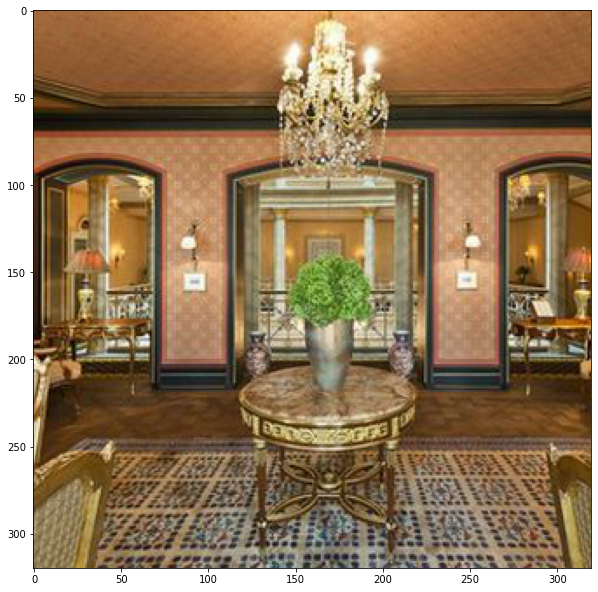

In [ ]:
vase_original = res
plt.figure(figsize=(10, 12))
plt.imshow(res.detach().cpu().numpy()[0].transpose(1,2,0))

# Part 3. Variational Autoencoder (VAE) — 15 points

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


### Prepare the data

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-05-13 08:47:34--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-05-13 08:47:34 (34.7 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [ ]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [ ]:
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

In [ ]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [ ]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [ ]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

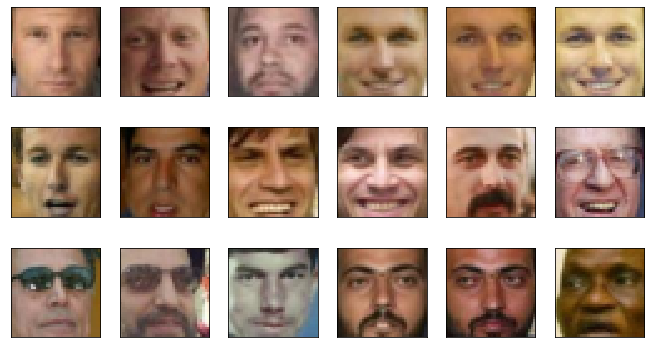

In [ ]:
plot_gallery(X_train, image_h, image_w)

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

## Autoencoder

Why to use all this complicated formulas and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" alt="Autoencoder">

In [ ]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #TODO
        
        self.encoder = nn.Sequential(
            nn.Linear(36 * 36 * 3, 1000),
            nn.LeakyReLU(negative_slope= 0.1),
            nn.Linear(1000, dimZ),
            nn.LeakyReLU(negative_slope= 0.1))
        nn.init.xavier_uniform_(self.encoder[0].weight.data)
        self.encoder[0].bias.data.fill_(0.)
        nn.init.xavier_uniform_(self.encoder[2].weight.data)
        self.encoder[2].bias.data.fill_(0.)
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1000),
            nn.LeakyReLU(negative_slope= 0.1),
            nn.Linear(1000, 36 * 36 * 3),
            nn.LeakyReLU(negative_slope= 0.1),
            nn.Sigmoid())
        nn.init.xavier_uniform_(self.decoder[0].weight.data)
        self.decoder[0].bias.data.fill_(0.)
        nn.init.xavier_uniform_(self.decoder[2].weight.data)
        self.decoder[2].bias.data.fill_(0.)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [ ]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr = 0.001)


In [ ]:
print(device)

cuda


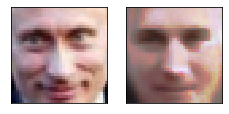

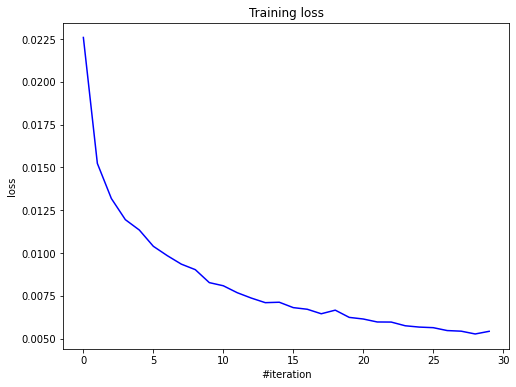

In [ ]:
from IPython import display

num_epochs = 30
loss_history = []
image_progress = []

for epoch in range(num_epochs):
    loss_epoch = []
    for i, data in enumerate(train_loader):
        img, _ = data
        img = img.to(device)
        output, latent = autoencoder(img)
        if i == 0:
            for j, data in enumerate(val_loader, 0):
              if j == 2754:
                inp = data[0].cuda()
                pred, _ = autoencoder(inp)
                image_progress.append(pred)
                plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    loss_history.append(np.mean(loss_epoch))
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

# Visualize progress in reconstruction and loss decay

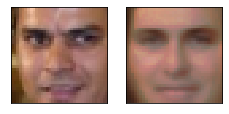

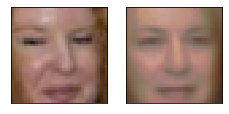

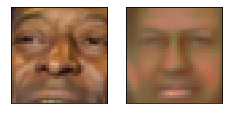

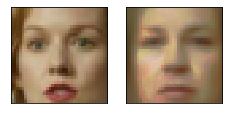

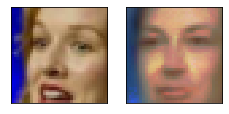

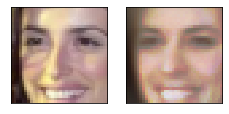

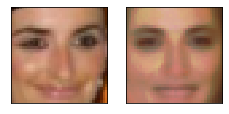

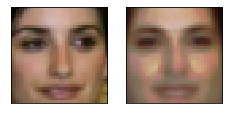

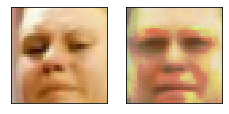

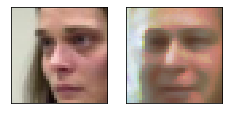

In [ ]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = data[0].cuda()
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

## Sampling

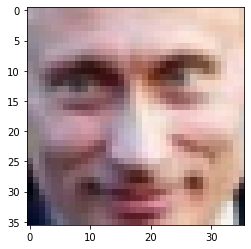

In [ ]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

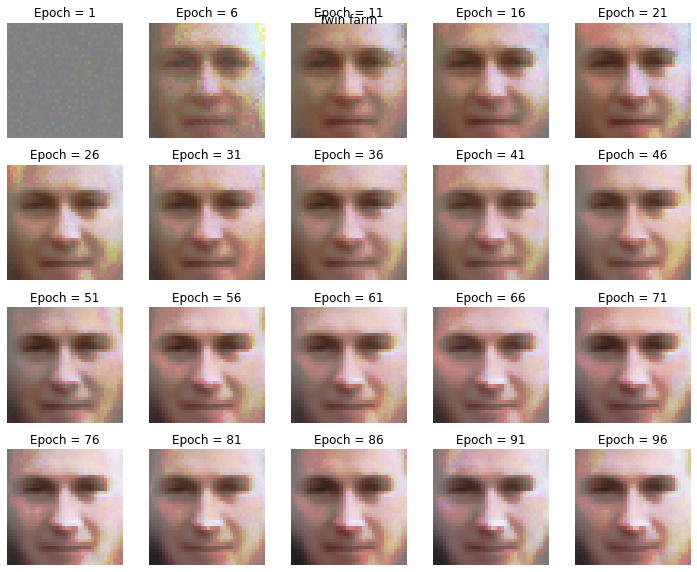

In [ ]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

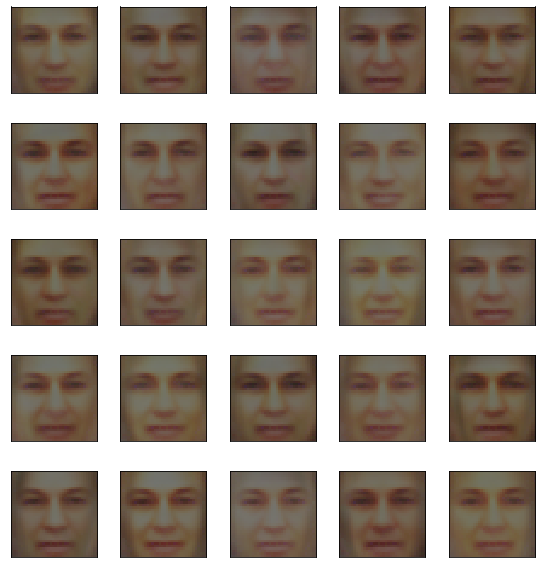

In [ ]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(torch.from_numpy(z).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

I think, no, because the training dataset limits possible variations of faces(there are not enough extremely rare faces etc.). Moreover, all sample faces look quite similar, I think it is because of the size of latent space - we can't reconstruct enough features, but with dataset limitations we can't train better transforms for a bigger latent space.

## Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [ ]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(36 * 36 * 3, 800)
        nn.init.xavier_uniform_(self.fc1.weight.data)
        self.fc1.bias.data.fill_(0.)
        self.fc21 = nn.Linear(800, dimZ)
        nn.init.xavier_uniform_(self.fc21.weight.data)
        self.fc21.bias.data.fill_(0.)
        self.fc22 = nn.Linear(800, dimZ)
        nn.init.xavier_uniform_(self.fc22.weight.data)
        self.fc22.bias.data.fill_(0.)
        self.fc3 = nn.Linear(dimZ, 800)
        nn.init.xavier_uniform_(self.fc3.weight.data)
        self.fc3.bias.data.fill_(0.)
        self.fc41 = nn.Linear(800, 36 * 36 * 3)
        nn.init.xavier_uniform_(self.fc41.weight.data)
        self.fc41.bias.data.fill_(0.)
        self.fc42 = nn.Linear(800, 36 * 36 * 3)
        nn.init.xavier_uniform_(self.fc42.weight.data)
        self.fc42.bias.data.fill_(0.)        
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu

    def encode(self, x):
        h1 = F.leaky_relu(self.fc1(x), negative_slope = 0.03)
        return self.fc21(h1), F.softplus(self.fc22(h1))

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z), negative_slope = 0.03)
        return self.fc41(h3), F.softplus(self.fc42(h3))

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        mu_gen, logsigma_gen = self.decode(z)
        return mu_gen, logsigma_gen, mu, logsigma        
        #TODO
        # return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as an input. Explain, why not $\sigma$?

to get wider range of values and for numerical stability.

In [ ]:
import math
def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + 2* logsigma - mu.pow(2) - (logsigma * 2).exp())

def log_likelihood(x, mu, logsigma):
    pi = math.pi
    res = torch.div(- (mu - x).pow(2), 2 * (logsigma * 2).exp()).exp()
    res = res.mul((logsigma.exp() * (2 * pi) ** 0.5).pow(-1))
    return torch.sum(res.log())

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return - KL_divergence(mu_z, logsigma_z) + 0.5 * log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

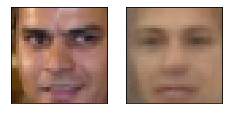

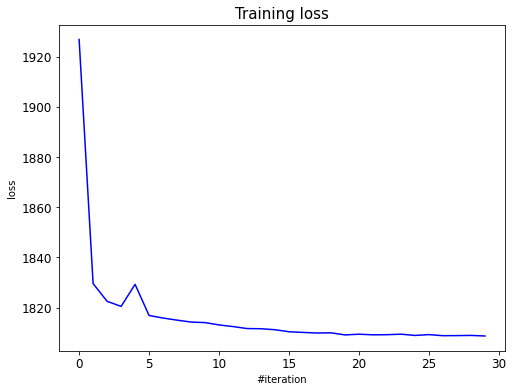

In [ ]:
# Create MSE loss function
autoencoder = VAE().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr = 0.001)




num_epochs = 30
loss_history = []
image_progress = []

for epoch in range(num_epochs):
    loss_epoch = []
    for i, data in enumerate(train_loader):
        img, _ = data
        img = img.to(device)
        mu_ge, logsigma_gen, mu_z, logsigma_z = autoencoder(img)
        loss = - loss_vae(img, mu_ge, logsigma_gen, mu_z, logsigma_z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item()/data[0].shape[0])
        if i == 0:
            for ind, val_data in enumerate(val_loader):
              if ind == 0:
                inp = val_data[0].cuda()
                mu_ge, _, _, _ = autoencoder(inp)
                image_progress.append(mu_ge)
                plot_gallery([val_data[0].numpy(), mu_ge.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    loss_history.append(np.mean(loss_epoch))
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

# Visualize progress in reconstruction and loss decay

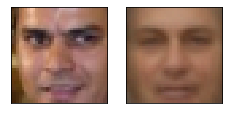

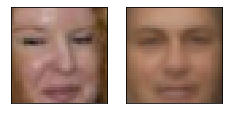

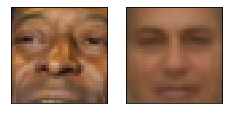

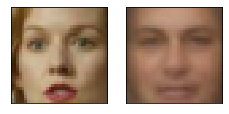

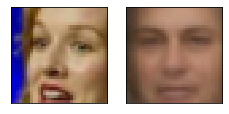

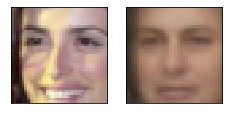

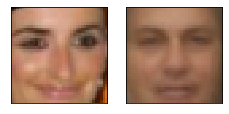

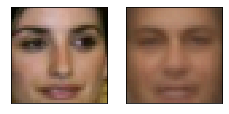

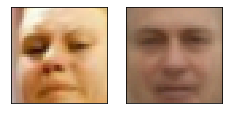

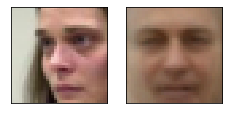

In [ ]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)
autoencoder.eval()
for j, data in enumerate(val_loader, 0):
    input = data[0].cuda()
    gen_mu, _, _, _ = autoencoder(input)
    plot_gallery([data[0].numpy(), gen_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

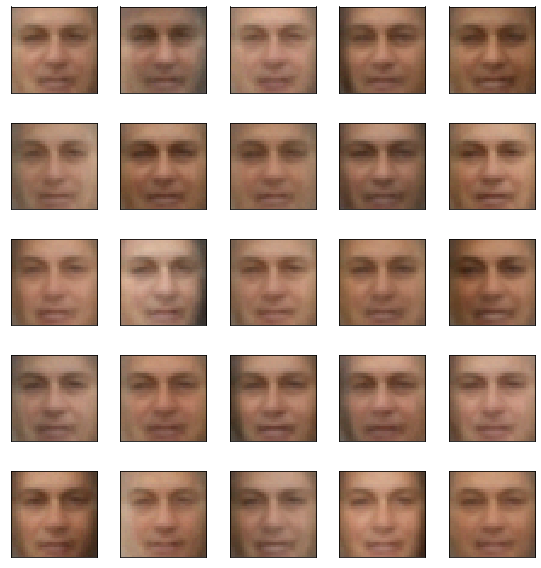

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = torch.randn((25, dimZ)).cuda()
gen_mu, gen_sigma = autoencoder.decode(z)
sample = gen_mu + torch.randn((25, 3888)).cuda() * gen_sigma
plot_gallery(sample.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

Though the faces aren't very different, they look more like peolple then given by AE.

### If you are going to do part 4 (presicion-recall score): 

In [ ]:
# using your model, generate face set with len = len(data)
answ = <generated dataset>

### Save it ot npz

In [ ]:
np.savez("vae.npz", Pictures=answ)

## Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [ ]:
# TODO

# Part 4. Generative Adversarial Networks (GANs) — 15 points

## Links

- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

## Theory

### Intro

Now we will consider another implicit generative model.

Implicit models (in contrary to explicit VAE), do not provide a direct access to the modeled data distribution $p(x)$, but only allow to sample from it.

Though this may be an advantage rather than a disadvantage. Most of the explicit models have to make assumptions about the shape of the data distribution. For example, in VAEs the assumption is that each image comes from a normal distribution, with each pixel being _independent_ of each other. Needless to say, this model is far from being ideal for modelling the natural images, because we all know that pixels in the image strongly depend not only on their neighbours, but sometimes on the global context as well.

<img src="https://bit.ly/3567LM6" width=320px>

This is why it is hard for us to believe that the image above is real, even though all local patches are perfectly real :)

### Method description

In order to overcome limitations of tracktable families of probabilistic models, we have to go intractable. Currently, Generative Adversarial Networks is the most successful example of such models.

__Key idea__ of GANs is the use of a loss function that is trained from the data.

A good analogy is a counterfeiter vs a cop example:

<img src="https://www.cfml.se/img/blog/generative_adversarial_networks/counterfeiter_vs_cop.jpg" width=640px>

A counterfeiter is a "generator" neural network that is being trained to produce realistic data points (not neccessarily images). A cop is a "discriminator" neural network trained to recognize fake data points. The counterfeiter gets constant updates from the cop via a gradient flow (backpropagation) and tries to maximize the realism score a cop is assigning to fake data points. The cop receives the feedback via the update of the available dataset, and tries to maximize the recognition accuracy.

If we denote $G$ as a generator, with $\hat{x}$ being its output, $D$ as a discriminator and $\mathcal{L}(s, \hat{s})$ as a classification function (with $s$ denoting class scores) the cop would want to minimize (say, binary cross entropy), then the objective can be written as a zero-sum game (since a classification function is typically symmetric w.r.t. classes): 

$$
    \max_G \min_D \mathcal{L} \big( D(x), D(\hat{x}) \big).
$$

In practice, however, for numerous reasons it is useful to separate this single objective into two, leading to a potentially non-zero sum game:

$$
    \max_G \min_D \mathcal{L}_G \big( D(x), D(\hat{x}) \big) + \mathcal{L}_D ( D(x), D(\hat{x}) \big),
$$

with gradients from the objective $\mathcal{L}_G$ being back-propagated only into the generator, and $\mathcal{L}_D$ — only into the discriminator.

### Training stability

The objective above is typically optimized via an alternating stochastic gradient descend technique: i.e., we first do an optimization step w.r.t. one network, and then use updated weights to perform a step w.r.t. another network. Although this technique has convergence issues [1], it is still widely used for its simplicity and memory efficiency.

Also, although GANs used to be notoriously hard to train, a number of techniques [2, 3] have been developed to overcome the difficulties.

Still, when we are talking about GANs, it is incorrect to use a term "convergence", because even with the aforementioned techniques, the optimization process does not converge to a state when the loss of the generator converges to zero. On contrary, it is a __red flag__ indicating a __training instability__ if this loss converges to zero. In practice, this means that the generator is fooling the discriminator with garbage.

Ideal training curves look like that:

<img src="https://i.ibb.co/0csVDhH/gans-training-curves.png" alt="source: https://deepai.org/publication/geogan-a-conditional-gan-with-reconstruction-and-style-loss-to-generate-standard-layer-of-maps-from-satellite-images" width=640px>

Bad training curves look like that:

<img src="https://miro.medium.com/max/2732/1*4A5bo8gVG9wmg-5wtqavOg.png" width=640px>

The weights of both the generator and discriminator keep constantly updating during training, resulting in a typical oscilation behavior [1].

Usually ideal training curves end up like the bad ones if you train long enough — all you can do is taking a checkpoint right before the training collapses (you can see this point clearly on the second plot). If the training process was stable, this collapse happends long after the results have stopped improving, though some models still struggle to obtain stable enough behavior for data with high dimensionality [4].

## Task

Implement and train a generative adversarial network using the provided dataset in 3 variants:

1. with a spectral normalization,
2. with a gradient penalty,
3. without any regularization.

Also try turning on and off batch normalization in the generator network for all approaches. Note that spectral normalization and batch normalization can be used simultaneously, since SN is only applied to linear and convolutional layers.

Visualize the resulting learning curves for all approaches and provide a side-by-side comparison for a small (~10 items) subset of samples for each method. Your learning curves should look similar to the "ideal" curves above.

## Notes

- Use Adam optimizer with $\beta_1 = 0$ for both the generator and the discriminator.
- Start with the learning rate equal to $1 \cdot 10^{-4}$ for both networks. Increase the learning rate by a factor of 4 for the discriminator, when using spectral normalization.
- Use PyTorch implementation of spectral normalization (__torch.nn.utils.SpectralNorm__). Implement a gradient penalty by hand using the following equations and __torch.autograd.grad__ (pass discriminator outputs to _outputs_, inputs to _inputs_, and ones to grad_outputs, set _retain_graph_ to True):


$$
    \mathcal{L}_\text{GP} = 10 \cdot \mathbb{E}_{x \sim p(x)} (||\nabla_x D(x)||_2 - 1)^2
$$

- Use hinge loss for training, but feel free to experiment with other losses as well for bonus points.

\begin{aligned}
    & \mathcal{L}_D = \mathbb{E}_{x \sim p(x)}\, \text{min}\big( 0, 1 - D(x) \big) + \mathbb{E}_{z \sim p(z)}\, \text{min}\big( 0, 1 + D(G(z)) \big) \\
    & \mathcal{L}_G = - \mathbb{E}_{z \sim p(z)}\, D(G(z))
\end{aligned}

## References

[1] Mescheder et. al., "Which Training Methods for GANs do actually Converge?", ICML 2018, https://arxiv.org/abs/1801.04406

[2] Miyato et. al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018, https://arxiv.org/abs/1802.05957

[3] Gulrajani et. al., "Improved Training of Wasserstein GANs", NeurIPS 2017, https://arxiv.org/abs/1704.00028

[4] Brock et. al., "Large Scale GAN Training for High Fidelity Natural Image Synthesis", ICLR 2018, https://arxiv.org/abs/1809.11096

In [ ]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


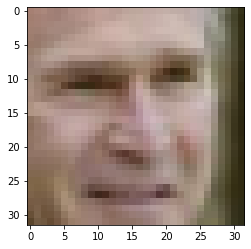

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data,attrs = fetch_lfw_dataset(dimx=32, dimy=32)

# Preprocess faces
data = np.float32(data).transpose([0, 3, 1, 2]) / 127.5 - 1.0

IMG_SHAPE = data.shape[1:]

# Print random image
plt.imshow(((data[np.random.randint(data.shape[0])] + 1) / 2.0).transpose([1, 2, 0]),
           cmap="gray", interpolation="none")

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.5.0+cu101
Using GPU


In [ ]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

### Generator

Example generator architecture is provided below: use it as a reference for you architectures, but feel free to experiment. If your experiments are shown to improve over baseline performance, you will be rewarded with bonus points.

In our realization, please insert batch normalization before nonlinearities.

In [ ]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 256 * 4 * 4),
    Reshape([-1, 256, 4, 4]),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2),
    nn.Conv2d(32, 3, kernel_size=3, padding=1),
    nn.BatchNorm2d(3),
    nn.Tanh()
)

if use_cuda: generator.cuda()

In [ ]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE,generated_data.shape)

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

The network does not include dropout/batchnorm to avoid learning complications.

The convolutional part of the discriminator should mirror the generator (with the exception of the first and the last layers).

In [ ]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.shape[0], -1)

In [ ]:
from torch.nn.utils import spectral_norm

discriminator = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1, bias=False),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1, bias=False),
            #nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=4),
            # state size. (ndf*8) x 4 x 4
            Flatten(),
            nn.Linear(256*2*2, 1))

if use_cuda: discriminator.cuda()

In [ ]:
discriminator(sample_data_batch(5))

tensor([[0.5214],
        [1.1454],
        [0.8524],
        [0.6426],
        [1.2671]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
def train_dis(batch_size):
    # Forward real
    real_data = sample_data_batch(batch_size).float().cuda()
    
    real_scores = discriminator(real_data)
    
    # Forward fake
    noise = sample_noise_batch(batch_size).float().cuda()
    gen_data = generator(noise)

    fake_scores = discriminator(gen_data.detach())

    # Discriminator losses
    real = discriminator(real_data)
    
    fake = discriminator(gen_data)
    max_module = nn.ReLU()
    loss_D = torch.mean(max_module(1.0 - real)) + torch.mean(max_module(1.0 + fake))
    loss_D += calc_gradient_penalty(discriminator, real_data.data, gen_data.data, batch_size)
    
    # Discriminator step
    dis_opt.zero_grad()
    loss_D.backward()
    dis_opt.step()
        
    return loss_D.item()

In [ ]:
def train_gen(batch_size):
    # Forward fake
    noise = sample_noise_batch(batch_size).float().cuda()
    gen_data = generator(noise)

    fake_scores = discriminator(gen_data)

    loss_G = -torch.mean(fake_scores)
                           
    gen_opt.zero_grad()
    loss_G.backward()
    gen_opt.step()
    
    return loss_G.item()

In [ ]:
lr_init = 1e-4
dis_opt = torch.optim.Adam(discriminator.parameters(), betas = (0, 0.999), lr = lr_init)
gen_opt = torch.optim.Adam(generator.parameters(), betas = (0, 0.999), lr = lr_init)

In [ ]:
def sample_images(data, generator, nrow, ncol):
    images = generator(sample_noise_batch(batch_size = nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images) != 0:
        images = (images +1)/2
    plt.figure(figsize=(16,12))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(images[i], cmap="gray")
    plt.show()

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

### Without any regulation

![alt text](https://)

Sampled images after training for epoch = 1500, batch size = 512, discriminator loss type = hinge, no training tricks


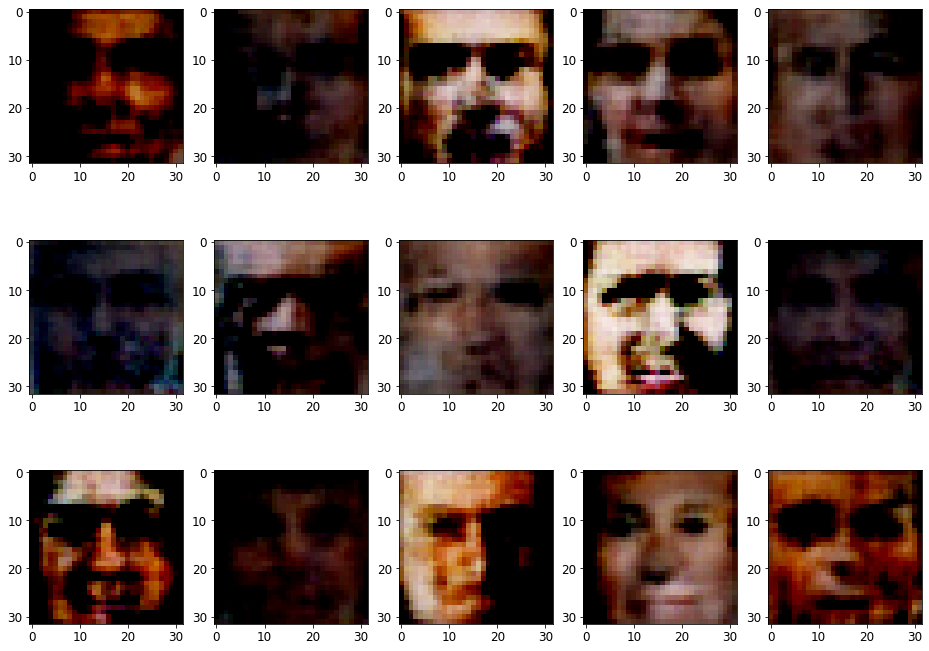

In [ ]:
num_epochs = 1500
batch_size = 512
sample_images(data = data, generator = generator, nrow = 3, ncol = 5)

In [ ]:
from torch.nn.utils import spectral_norm

discriminator = nn.Sequential(
            # input is (nc) x 32 x 32
            spectral_norm(nn.Conv2d(3, 32, kernel_size = 3, padding = 1, bias=False)),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 16 x 16
            spectral_norm(nn.Conv2d(32, 64, 4, 2, 1, bias=False)),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 8 x 8
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            spectral_norm(nn.Conv2d(128, 256, kernel_size = 3, padding = 1, bias=False)),
            #nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=4),
            # state size. (ndf*8) x 4 x 4
            Flatten(),
            spectral_norm(nn.Linear(256*2*2, 1))
        )

if use_cuda: discriminator.cuda()

### Spectral norm

Iter 1495 took 1.067 s


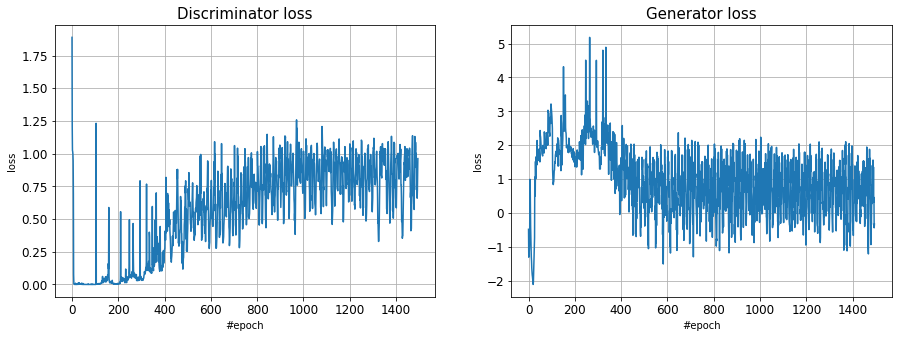

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import time
%matplotlib inline


batch_size = 4
losses_D_hist = []
losses_G_hist = []


titles = ['Discriminator loss', 'Generator loss']

for i in range(1, 1500):
    start_time = time.time()
    epoch_loss_D = []    
    discriminator.train(True)
    generator.train(False)
    for _ in range(5):
        loss_D = train_dis(128)
        epoch_loss_D.append(loss_D)
    discriminator.train(False)
    generator.train(True)
    loss_G = train_gen(128)
    
    losses_D_hist.append(np.mean(epoch_loss_D))
    losses_G_hist.append(loss_G)
    
    if i % 10 == 5:
        display.clear_output(wait=True)
        print('Iter {} took {:.3f} s'.format(i, time.time() - start_time))
        
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        for j in range(2):
          axs[j].set_xlabel("#epoch")
          axs[j].set_ylabel("loss")
          axs[j].grid(True)
          axs[j].set_title(titles[j])
        axs[0].plot(losses_D_hist)
        axs[1].plot(losses_G_hist)
        plt.show()

    if i % 10 == 0:
      display.clear_output(wait=True)
      sample_images(data = data, generator = generator, nrow = 2, ncol = 5)

batch-size = 128, 1500 iterations

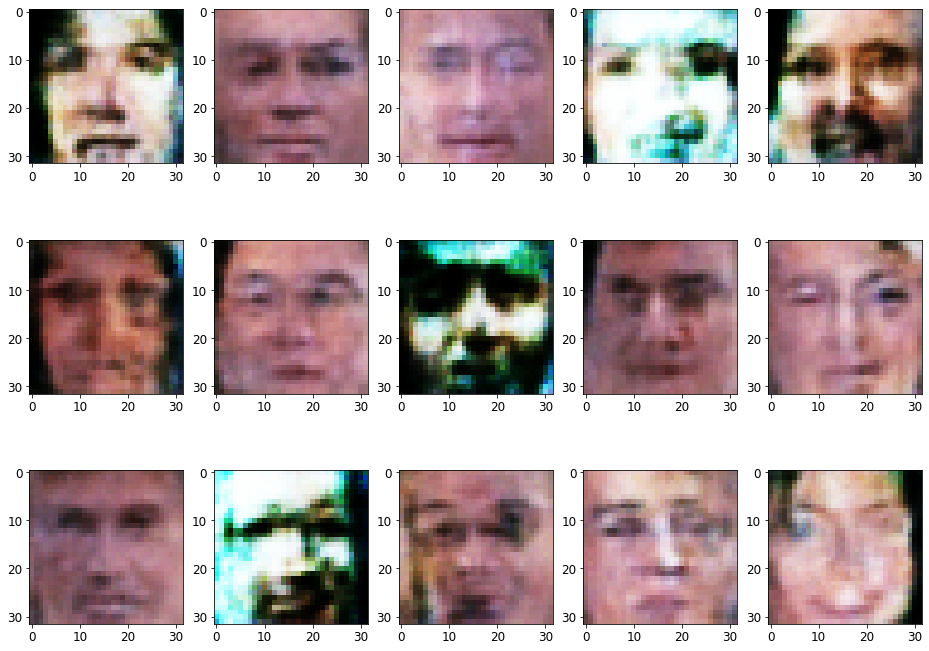

In [ ]:
sample_images(data = data, generator = generator, nrow = 3, ncol = 5)

I didn't have enough time to tune the net, I think the discriminator should be stronger, so I would either increase its amount of iteration during epoch, or create more parameters.

Iter 1495 took 0.610 s


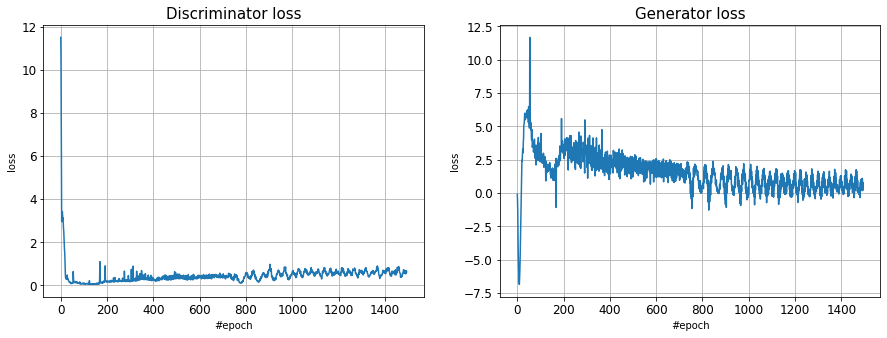

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import time
%matplotlib inline
from torch.autograd import Variable
from torch import autograd
def calc_gradient_penalty(D_net, real_data, fake_data, batch_size, Lambda = 10, eps = 1e-10):
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand(real_data.size()).cuda()


    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = autograd.Variable(interpolates, requires_grad = True)
    if use_cuda:
        interpolates = interpolates.cuda() 
    discriminator_interpolates = D_net(interpolates)
    ones = torch.ones(discriminator_interpolates.size()).cuda() 
    
    gradients = autograd.grad(outputs = discriminator_interpolates, inputs = interpolates,
                              grad_outputs = ones,
                              create_graph = True, retain_graph = True, only_inputs = True)[0]
    gradients = gradients.reshape(batch_size, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + eps)
    gradient_penalty = ((gradients_norm - 1.0) ** 2).mean() * Lambda
    return gradient_penalty


batch_size = 4
losses_D_hist = []
losses_G_hist = []


titles = ['Discriminator loss', 'Generator loss']

for i in range(1, 1500):
    start_time = time.time()
    epoch_loss_D = []    
    discriminator.train(True)
    generator.train(False)
    for _ in range(5):
        loss_D = train_dis(128)
        epoch_loss_D.append(loss_D)
    discriminator.train(False)
    generator.train(True)
    loss_G = train_gen(128)
    
    losses_D_hist.append(np.mean(epoch_loss_D))
    losses_G_hist.append(loss_G)
    
    if i % 10 == 5:
        display.clear_output(wait=True)
        print('Iter {} took {:.3f} s'.format(i, time.time() - start_time))
        
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        for j in range(2):
          axs[j].set_xlabel("#epoch")
          axs[j].set_ylabel("loss")
          axs[j].grid(True)
          axs[j].set_title(titles[j])
        axs[0].plot(losses_D_hist)
        axs[1].plot(losses_G_hist)
        plt.show()

    if i % 10 == 0:
      display.clear_output(wait=True)
      sample_images(data = data, generator = generator, nrow = 2, ncol = 5)

As it can be seen, the generator and discriminator penalt each other, unfortunately, I hadn't enough time to get to plato.

### with gradient penalty(today and yesterday, I didn't fix random state anywhere)

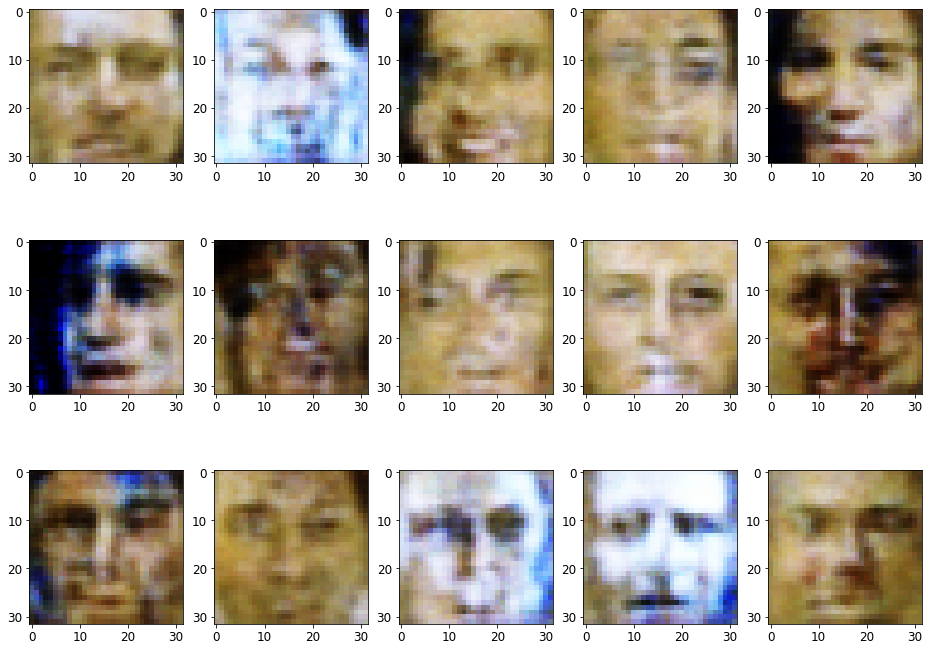

In [ ]:
sample_images(data = data, generator = generator, nrow = 3, ncol = 5)

Sampled images after training for epoch = 1500, batch size = 512, discriminator loss type = hinge, no training tricks


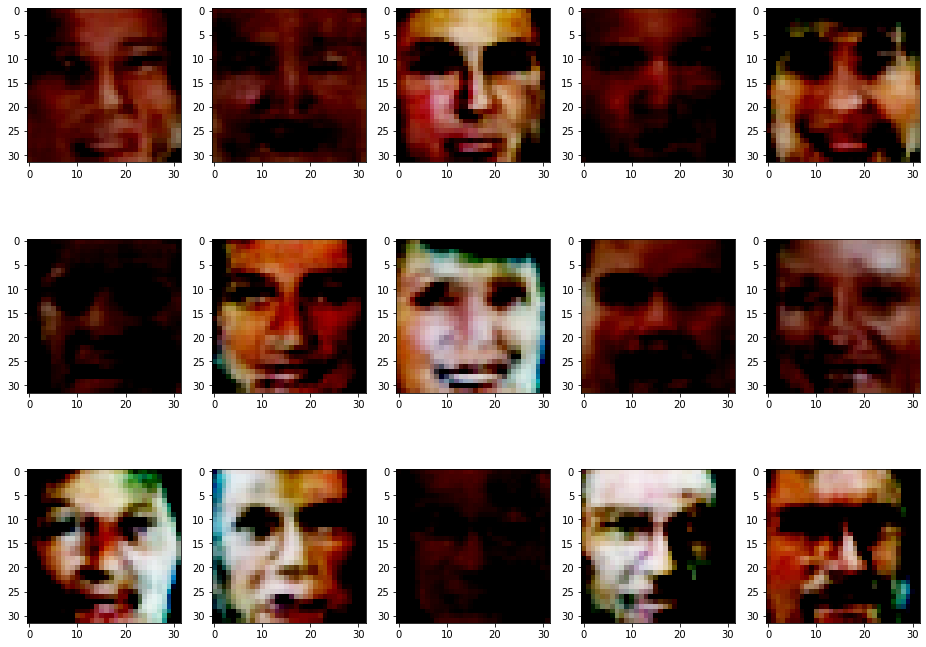

In [ ]:
sample_images(data = data, generator = generator, nrow = 3, ncol = 5)

these are my results without regularization(I had 2 colabs to train, as 1 terminated at night and deleted output pictures and I had to ran experiments in 2 notebooks) 

![picture](https://drive.google.com/uc?id=1marpPA6DOblEDvZ7YRUpXsSjFm3AhejK)

From my opinion results with regularization look better, and I can't tell about the difference between images got when using gradient penalty, or spectral norm. Gradient penalty gave "normal results" with noses and eyes earlier than the spactral norm.